## [1주차] 심화과제 - MNIST 예측 모델에 deep learning techniques 적용하기

과제 목표: 기존 mnist-classification-basic 에서 구현한 코드를 기반으로, 필요한 부분을 수정하거나 기능을 추가합니다.

### 1. 필요한 라이브러리 import

In [1]:
import torch
import torchvision
import torchvision.transforms as transforms

### 2. CIFAR10 Dataset 로딩
- Dataset을 MNIST에서 CIFAR10으로 변경해줍니다.

In [2]:
transform = transforms.ToTensor()

trainset = torchvision.datasets.CIFAR10(
    root='./data',
    train=True,
    download=True,
    transform=transform
)

testset = torchvision.datasets.CIFAR10(
    root='./data',
    train=False,
    download=True,
    transform=transform
)

100.0%


### 3. 데이터 확인
- CIFAR10은 MNIST와 다른 입력 shape을 가지고 있습니다.
- 입력 shape은 model을 선언할 때 중요하기 때문에 MNIST 실습 자료에서 사용한 방식과 똑같이 shape을 확인합니다.

50000
torch.Size([3, 32, 32]) 6


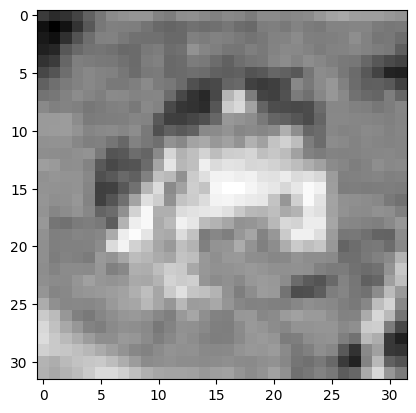

In [3]:
from matplotlib import pyplot as plt

print(len(trainset))
print(trainset[0][0].shape, trainset[0][1])
plt.imshow(trainset[0][0][0], cmap='gray')

### 4. DataLoader 생성

In [4]:
batch_size = 256

trainloader = torch.utils.data.DataLoader(
    trainset,
    batch_size=batch_size,
    shuffle=True
)

testloader = torch.utils.data.DataLoader(
    testset,
    batch_size=batch_size,
    shuffle=False
)

### 5. 첫 번째 batch 확인

In [5]:
dataiter = iter(trainloader)
images, labels = next(dataiter)
print(images.shape, labels.shape)

torch.Size([256, 3, 32, 32]) torch.Size([256])


### 6. MLP 모델 정의
- Activation 함수를 nn.ReLU에서 nn.LeakyReLU로 변경합니다.
- CIFAR10은 (3, 32, 32) size 이므로, **Model(3 * 32 * 32, 1024)로 생성**합니다.
- LeakyReLU를 사용한 기본 Model을 정의합니다.

In [6]:
from torch import nn


class Model(nn.Module):
    def __init__(self, input_dim, n_dim):
        super().__init__()
        self.layer1 = nn.Linear(input_dim, n_dim)
        self.layer2 = nn.Linear(n_dim, n_dim)
        self.layer3 = nn.Linear(n_dim, 10)
        self.act = nn.LeakyReLU()

    def forward(self, x):
        x = torch.flatten(x, start_dim=1)
        x = self.act(self.layer1(x))
        x = self.act(self.layer2(x))
        x = self.layer3(x)
        return x


model = Model(3 * 32 * 32, 1024)

### 7. 정확도 측정 함수 정의

In [7]:
def accuracy(model, dataloader):
    cnt = 0
    acc = 0

    model.eval()
    with torch.no_grad():
        for data in dataloader:
            inputs, labels = data
            inputs, labels = inputs.to('cuda'), labels.to('cuda')

            preds = model(inputs)
            preds = torch.argmax(preds, dim=-1)

            cnt += labels.shape[0]
            acc += (labels == preds).sum().item()
    model.train()
    return acc / cnt

### 8. 모델 학습
- 학습 인자는 n_epochs = 50 으로 설정합니다.
- 여러 모델을 학습시키기 위해서 모델 학습 함수를 따로 정의합니다.
    - Model: LeakyReLU() 사용한 기본 Model
    - Model_Sigmoid: Sigmoid() 사용한 기본 Model

In [8]:
def train(model, optimizer):
    n_epochs = 50
    model = model.to('cuda')
    train_accs = []

    for epoch in range(n_epochs):
        total_loss = 0.

        for data in trainloader:
            inputs, labels = data
            inputs, labels = inputs.to('cuda'), labels.to('cuda')

            optimizer.zero_grad()
            preds = model(inputs)
            loss = nn.CrossEntropyLoss()(preds, labels)
            loss.backward()
            optimizer.step()

            total_loss += loss.item()

        train_acc = accuracy(model, trainloader)
        train_accs.append(train_acc)

        print(f"Epoch {epoch:3d} | Loss: {total_loss}")

    return train_accs

### 9. 정확도 시각화
- 정확도 시각화를 위한 함수를 정의합니다.

In [9]:
def plot_acc(acc_lists, labels, title):
    for acc, label in zip(acc_lists, labels):
        x = np.arange(len(acc))
        plt.plot(x, acc, label=label)
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.title(title)
    plt.show()

### 10. Plot 1 - SGD vs Adam

Epoch   0 | Loss: 450.28078627586365
Epoch   1 | Loss: 448.06680488586426
Epoch   2 | Loss: 446.21130442619324
Epoch   3 | Loss: 444.37434816360474
Epoch   4 | Loss: 442.4800124168396
Epoch   5 | Loss: 440.414115190506
Epoch   6 | Loss: 438.18549847602844
Epoch   7 | Loss: 435.78039503097534
Epoch   8 | Loss: 433.16779613494873
Epoch   9 | Loss: 430.37061738967896
Epoch  10 | Loss: 427.46008467674255
Epoch  11 | Loss: 424.482031583786
Epoch  12 | Loss: 421.4029629230499
Epoch  13 | Loss: 418.45939683914185
Epoch  14 | Loss: 415.5639717578888
Epoch  15 | Loss: 412.8538465499878
Epoch  16 | Loss: 410.2949459552765
Epoch  17 | Loss: 407.9402484893799
Epoch  18 | Loss: 405.7229232788086
Epoch  19 | Loss: 403.6913080215454
Epoch  20 | Loss: 401.66666626930237
Epoch  21 | Loss: 399.7748279571533
Epoch  22 | Loss: 398.0252139568329
Epoch  23 | Loss: 396.33467233181
Epoch  24 | Loss: 394.72303318977356
Epoch  25 | Loss: 393.19023871421814
Epoch  26 | Loss: 391.6166549921036
Epoch  27 | Loss: 3

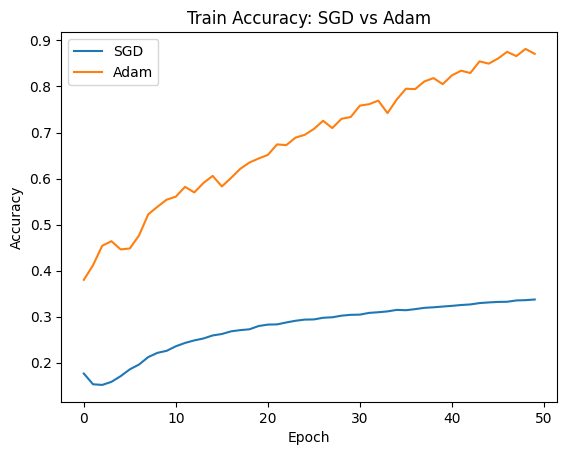

In [10]:
from torch.optim import SGD, Adam
import numpy as np

sgd_model = model.to('cuda')
adam_model = model.to('cuda')

sgd_accs = train(sgd_model, SGD(sgd_model.parameters(), lr=0.001))
adam_accs = train(adam_model, Adam(adam_model.parameters(), lr=0.001))

plot_acc([sgd_accs, adam_accs], ["SGD", "Adam"], "Train Accuracy: SGD vs Adam")

### 11. MLP 모델 정의 2
- Sigmoid를 사용한 기본 Model을 정의합니다.

In [11]:
class Model_Sigmoid(Model):
    def __init__(self, input_dim, hidden_dim):
        super().__init__(input_dim, hidden_dim)
        self.act = nn.Sigmoid()


model_sigmoid = Model_Sigmoid(3 * 32 * 32, 1024)

### 12. Plot 2 - LeakyReLU vs Sigmoid (Adam)


Epoch   0 | Loss: 74.07212841510773
Epoch   1 | Loss: 69.59333181381226
Epoch   2 | Loss: 65.93355914950371
Epoch   3 | Loss: 65.47293744981289
Epoch   4 | Loss: 62.28989163041115
Epoch   5 | Loss: 59.777705773711205
Epoch   6 | Loss: 60.771269008517265
Epoch   7 | Loss: 58.047598868608475
Epoch   8 | Loss: 55.114128455519676
Epoch   9 | Loss: 50.25709445774555
Epoch  10 | Loss: 49.13353829085827
Epoch  11 | Loss: 49.64255014061928
Epoch  12 | Loss: 51.902634382247925
Epoch  13 | Loss: 49.32301849126816
Epoch  14 | Loss: 50.408396139740944
Epoch  15 | Loss: 50.25848099589348
Epoch  16 | Loss: 44.928095795214176
Epoch  17 | Loss: 40.20495194196701
Epoch  18 | Loss: 42.02452892810106
Epoch  19 | Loss: 39.76926797628403
Epoch  20 | Loss: 41.07203055173159
Epoch  21 | Loss: 40.1163060888648
Epoch  22 | Loss: 37.038579024374485
Epoch  23 | Loss: 34.152844816446304
Epoch  24 | Loss: 36.91007722169161
Epoch  25 | Loss: 45.85758224129677
Epoch  26 | Loss: 46.900957845151424
Epoch  27 | Loss: 3

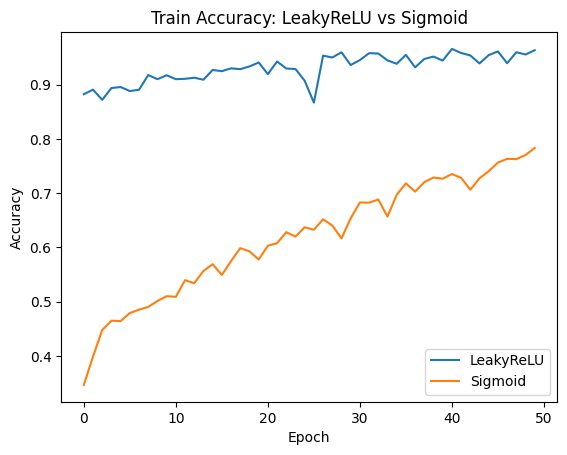

In [12]:
leaky_model = model.to('cuda')
sigmoid_model = model_sigmoid.to('cuda')

leaky_accs = train(leaky_model, Adam(leaky_model.parameters(), lr=0.001))
sigmoid_accs = train(sigmoid_model, Adam(sigmoid_model.parameters(), lr=0.001))

plot_acc([leaky_accs, sigmoid_accs], ["LeakyReLU", "Sigmoid"], "Train Accuracy: LeakyReLU vs Sigmoid")

### 13. MLP 모델 정의 3
- LeakyReLU + Dropout를 적용한 Model을 정의합니다.

In [14]:
class Model_Dropout(nn.Module):
    def __init__(self, input_dim, hidden_dim):
        super().__init__()
        self.layer1 = nn.Linear(input_dim, hidden_dim)
        self.layer2 = nn.Linear(hidden_dim, hidden_dim)
        self.layer3 = nn.Linear(hidden_dim, 10)
        self.act = nn.LeakyReLU()
        self.dropout = nn.Dropout(0.1)

    def forward(self, x):
        x = torch.flatten(x, start_dim=1)
        x = self.dropout(self.act(self.layer1(x)))
        x = self.dropout(self.act(self.layer2(x)))
        x = self.layer3(x)
        return x


model_dropout = Model_Dropout(3 * 32 * 32, 1024)

### 14. Plot 3 - Dropout 모델의 Train/Test Accuracy

Epoch   1 | Train: 0.3818, Test: 0.3842
Epoch   2 | Train: 0.4149, Test: 0.4105
Epoch   3 | Train: 0.4535, Test: 0.4448
Epoch   4 | Train: 0.4681, Test: 0.4650
Epoch   5 | Train: 0.4752, Test: 0.4595
Epoch   6 | Train: 0.4967, Test: 0.4773
Epoch   7 | Train: 0.4938, Test: 0.4733
Epoch   8 | Train: 0.5080, Test: 0.4884
Epoch   9 | Train: 0.5098, Test: 0.4828
Epoch  10 | Train: 0.5210, Test: 0.4879
Epoch  11 | Train: 0.5294, Test: 0.4932
Epoch  12 | Train: 0.5355, Test: 0.5001
Epoch  13 | Train: 0.5623, Test: 0.5205
Epoch  14 | Train: 0.5658, Test: 0.5165
Epoch  15 | Train: 0.5743, Test: 0.5277
Epoch  16 | Train: 0.5565, Test: 0.5164
Epoch  17 | Train: 0.5881, Test: 0.5255
Epoch  18 | Train: 0.5924, Test: 0.5264
Epoch  19 | Train: 0.5968, Test: 0.5227
Epoch  20 | Train: 0.6036, Test: 0.5312
Epoch  21 | Train: 0.6121, Test: 0.5232
Epoch  22 | Train: 0.6185, Test: 0.5327
Epoch  23 | Train: 0.6245, Test: 0.5303
Epoch  24 | Train: 0.6240, Test: 0.5295
Epoch  25 | Train: 0.6363, Test: 0.5368


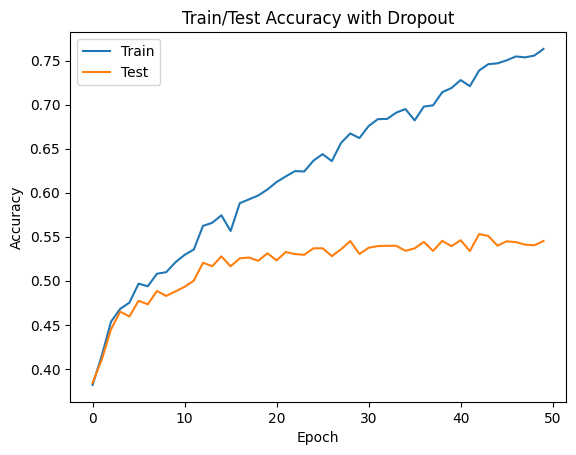

In [15]:
dropout_model = model_dropout.to('cuda')
optimizer = Adam(model_dropout.parameters(), lr=0.001)

n_epochs = 50
train_accs = []
test_accs = []

for epoch in range(n_epochs):
    dropout_model.train()
    for data in trainloader:
        inputs, labels = data
        inputs, labels = inputs.to('cuda'), labels.to('cuda')

        optimizer.zero_grad()
        pred = model_dropout(inputs)
        loss = nn.CrossEntropyLoss()(pred, labels)
        loss.backward()
        optimizer.step()

    with torch.no_grad():
        dropout_model.eval()
        train_accs.append(accuracy(dropout_model, trainloader))
        test_accs.append(accuracy(dropout_model, testloader))
    print(f"Epoch {epoch + 1:3d} | Train: {train_accs[-1]:.4f}, Test: {test_accs[-1]:.4f}")

plot_acc([train_accs, test_accs], ["Train", "Test"], "Train/Test Accuracy with Dropout")